<a href="https://colab.research.google.com/github/avk1943/Soccer-Event-Prediction/blob/main/Baseline_Model.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Import Libraries

Loading necessary libraries and mounting to google drive

In [1]:
import numpy as np; import pandas as pd; import sklearn as sk; import matplotlib.pyplot as plt; import seaborn as sns; import os
import random; from scipy import stats; from sklearn import preprocessing; from sklearn.preprocessing import OneHotEncoder,LabelEncoder
import numpy.lib.recfunctions as rfn; import statsmodels.api as sm; from statsmodels.graphics.regressionplots import abline_plot
import numpy as np; from sklearn.linear_model import LinearRegression; from sklearn.metrics import mean_squared_error, r2_score
import math; from sklearn import linear_model
from numpy import linalg; from scipy import stats; import cv2; import math; from matplotlib import cm; from matplotlib import colors
import matplotlib as mpl; from matplotlib.ticker import (AutoMinorLocator, MultipleLocator); import scipy.stats as st; import scipy as sp
mpl.rcParams['figure.dpi'] = 150 #default is 72.0
import os; print(os.getcwd())
from os import listdir
from os.path import isfile, join
from PIL import Image
from matplotlib import cm
import matplotlib.patches as mpatches
from torchvision.datasets.utils import download_url
from zipfile import ZipFile

gpu_info = !nvidia-smi
gpu_info = '\n'.join(gpu_info)
if gpu_info.find('failed') >= 0:
  print("CPU-only runtime")
else:
  print(gpu_info)

from psutil import virtual_memory
ram_gb = virtual_memory().total / 1e9
print('Your runtime has {:.1f} gigabytes of available RAM\n'.format(ram_gb))

import torch
import sklearn as sk
import matplotlib.pyplot as plt
import seaborn as sns
import os
import random
from numpy import linalg
from scipy import stats
import cv2
import math
from tqdm import tqdm
from matplotlib import cm
from matplotlib import colors
import matplotlib as mpl
from matplotlib.ticker import (AutoMinorLocator, MultipleLocator)
mpl.rcParams['figure.dpi'] = 150 #default is 72.0
import scipy.stats as st
import torch.optim as optim
torch.set_printoptions(precision=4,sci_mode=False)
import torch
import torch.nn.functional as F
import torchvision.transforms as transforms
from torch import nn
from torch import optim
from torch.utils.data import DataLoader
from torchvision.datasets import MNIST
from torch.utils.data import Dataset, DataLoader
from torch import nn
from torch.nn import functional as F
from torch import optim
import random
import sys
import io
!pip install py7zr
import py7zr
!pip install gdown

/content
Wed Jan  3 11:04:46 2024       
+---------------------------------------------------------------------------------------+
| NVIDIA-SMI 535.104.05             Driver Version: 535.104.05   CUDA Version: 12.2     |
|-----------------------------------------+----------------------+----------------------+
| GPU  Name                 Persistence-M | Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp   Perf          Pwr:Usage/Cap |         Memory-Usage | GPU-Util  Compute M. |
|                                         |                      |               MIG M. |
|=========================================+======================+======================|
|   0  Tesla T4                       Off | 00000000:00:04.0 Off |                    0 |
| N/A   39C    P8               9W /  70W |      0MiB / 15360MiB |      0%      Default |
|                                         |                      |                  N/A |
+-----------------------------------------+----------------

In [2]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [3]:
if torch.cuda.is_available():
    device = torch.device("cuda")
else:
    device = torch.device('cpu')
print("Using {}.".format(device))

Using cuda.


### Downloading relevent datasets from google drive

In [4]:
!gdown 1-3DDMv-yRn8eCni8mvWQBhdsvp880M79
df = pd.read_pickle("/content/drive/Shared drives/Soccer Event Prediction/fe_data.pkl")
df = df.reset_index()

Downloading...
From: https://drive.google.com/uc?id=1-3DDMv-yRn8eCni8mvWQBhdsvp880M79
To: /content/fe_data.pkl
100% 293M/293M [00:01<00:00, 158MB/s]


In [5]:
!gdown 1Jf3c4q6oXL5OzshFaTQ9lwQdhpzEJ_Kc    #Google Drive open access sharing link
teams_list = pd.read_csv("/content/soccer_teams_to_import.csv")

Downloading...
From: https://drive.google.com/uc?id=1Jf3c4q6oXL5OzshFaTQ9lwQdhpzEJ_Kc
To: /content/soccer_teams_to_import.csv
100% 1.36k/1.36k [00:00<00:00, 5.09MB/s]


Filtering matches and choosing the right set of matches

In [6]:
idx = np.repeat(False,len(df))
for i in range(len(teams_list)):
  idx0 = np.logical_and(df['comp'] == teams_list.loc[i,'Comp'],df['TID'] == teams_list.loc[i,'wyId'])
  idx = np.logical_or(idx,idx0)
df = df.loc[idx,:]

In [7]:
idx = np.repeat(False,len(df))
np.random.seed(123)
for i in range(len(teams_list)):
  tempteam = teams_list.loc[i,:]
  tempmatches = np.unique(df.loc[df["TID"]==tempteam['wyId'],"MID"])
  num_matches_to_choose = tempteam['trn'] + tempteam['val'] + tempteam['tst']
  matches_to_keep = np.random.choice(tempmatches,num_matches_to_choose,replace=False) # random (seeded) choice of matches to choose
  idx0 = np.logical_and(df['comp'] == tempteam['Comp'],df['TID'] == tempteam['wyId'])
  idx1 = np.logical_and(idx0,np.isin(df['MID'],matches_to_keep))
  idx = np.logical_or(idx,idx1)

In [8]:
df = df.loc[idx,:]
df = df.sort_values(by=['TID','MID','index'])
df = df.drop("index",axis=1)
df = df.reset_index(drop=True)
df = df.reset_index(drop=False)

Assigning match IDs

In [9]:
teams_list['trn_MIDs'], teams_list['val_MIDs'], teams_list['tst_MIDs'] = None, None, None
teams_list['n_trn'], teams_list['n_val'], teams_list['n_tst'] = 0, 0, 0
teams_list['trn_MIDs'], teams_list['val_MIDs'], teams_list['tst_MIDs'] = teams_list['trn_MIDs'].astype(object), teams_list['val_MIDs'].astype(object), teams_list['tst_MIDs'].astype(object)

np.random.seed(123)
for i in range(len(teams_list)):
  tempteam = teams_list.loc[i,:]
  tempteam_allmatches = np.unique(df.loc[df["TID"] == tempteam["wyId"],"MID"])
  np.random.shuffle(tempteam_allmatches)                       # perturbation: shuffle all of this team's MIDs in place
  teams_list['trn_MIDs'][i] = tempteam_allmatches[:tempteam["trn"]]
  teams_list['val_MIDs'][i] = tempteam_allmatches[tempteam["trn"]:(tempteam["trn"]+tempteam["val"])]
  teams_list['tst_MIDs'][i] = tempteam_allmatches[(tempteam["trn"]+tempteam["val"]):]
  teams_list['n_trn'][i] = np.sum(np.isin(df["MID"],teams_list['trn_MIDs'][i]))
  teams_list['n_val'][i] = np.sum(np.isin(df["MID"],teams_list['val_MIDs'][i]))
  teams_list['n_tst'][i] = np.sum(np.isin(df["MID"],teams_list['tst_MIDs'][i]))

teams_list

<ipython-input-9-0f129a58c97e>:14: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  teams_list['trn_MIDs'][i] = tempteam_allmatches[:tempteam["trn"]]
<ipython-input-9-0f129a58c97e>:15: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  teams_list['val_MIDs'][i] = tempteam_allmatches[tempteam["trn"]:(tempteam["trn"]+tempteam["val"])]
<ipython-input-9-0f129a58c97e>:16: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  teams_list['tst_MIDs'][i] = tem

,Comp,Pos,Team,trn,val,tst,wyId,trn_MIDs,val_MIDs,tst_MIDs,n_trn,n_val,n_tst
0,EN,1,Manchester City,3,0,0,1625,"[2499781, 2499822, 2499841]",[],[],2800,0,0
1,EN,2,Manchester United,0,0,3,1611,[],[],"[2499914, 2499898, 2500001]",0,0,2668
2,EN,10,Newcastle United,0,0,3,1613,[],[],"[2499964, 2500027, 2499823]",0,0,1867
3,EN,11,Crystal Palace,3,1,0,1628,"[2499741, 2499961, 2499774]",[2499894],[],1921,670,0
4,EN,19,Stoke City,0,0,3,1639,[],[],"[2499765, 2499805, 2499920]",0,0,1997
5,EN,20,West Bromwich Albion,3,0,0,1627,"[2500019, 2499792, 2499854]",[],[],1818,0,0
6,DE,1,Bayern Munich,3,0,0,2444,"[2517018, 2516982, 2516997]",[],[],2623,0,0
7,DE,2,Schalke 04,0,0,3,2449,[],[],"[2517011, 2516770, 2516797]",0,0,1929
8,DE,9,Borussia Mönchengladbach,0,0,3,2454,[],[],"[2516851, 2516778, 2516814]",0,0,2062
9,DE,10,Hertha BSC,3,1,0,2457,"[2516967, 2516840, 2516813]",[2516920],[],2226,669,0


Inserting buffer after each match for time and sequence processing

In [10]:
paddingrow = df.iloc[-1,:]
paddingrow = pd.DataFrame(paddingrow).T
paddingrow["comp"] = "na"       #need to update each time padding is added
paddingrow["TID"] = 123         #need to update each time padding is added
paddingrow["MID"] = 123         #need to update each time padding is added
paddingrow["index"] = 1000000000
paddingrow["PID"] = 1000000000
paddingrow["act"] = "@"
paddingrow["T"] = 0.5           #df["T"].mean()
paddingrow["deltaT"] = 0.5      #df["deltaT"].mean()
paddingrow["x"] = 0.5          #df["x"].mean()
paddingrow["y"] = 0.5          #df["y"].mean()
paddingrow["s"] = 0.2           #df["s"].mean()
paddingrow["scrad"] = 0.5       #df["scrad"].mean()
paddingrow["deltax"] = 0.5     #df["deltax"].mean()
paddingrow["deltay"] = 0.5     #df["deltay"].mean()
paddingrow["sg"] = 0.57         #df["sg"].mean()
paddingrow["thetag"] = 0.74     #df["thetag"].mean()
num_paddingrows=1
paddingrows = paddingrow.iloc[np.repeat(0,num_paddingrows),:]


#making a generic buffer row
def insert_rows(idx, df, df_to_insert):  # convenience function to insert a row
    dfA = df.iloc[:idx, ]
    dfB = df.iloc[idx:, ]
    df = dfA.append(df_to_insert).append(dfB).reset_index(drop = True)
    return df

#the idxn indicates the LAST row of a match (MID)
bufidxns = np.where(df["MID"][1:].to_numpy() != df["MID"][:-1].to_numpy())[0]

#inserting the buffers
for i in tqdm(range(0,len(bufidxns))):   # insert the padding/buffers
  # print(i)
  bufidxns = np.where(df["MID"][1:].to_numpy() != df["MID"][:-1].to_numpy())[0]  #recompute each time...
  bufidxn = bufidxns[i]
  paddingrows["comp"] = df.loc[bufidxn,"comp"]
  paddingrows["TID"] = df.loc[bufidxn,"TID"]
  paddingrows["MID"] = df.loc[bufidxn,"MID"]
  df = insert_rows(bufidxn+1,df,paddingrows)

df = df.drop("index",axis=1)
df = df.reset_index(drop=True)
df = df.reset_index(drop=False)

df = df.loc[:,['comp', 'TID', 'MID', 'index', 'PID', 'act', 'T', 'x', 'y', 'sg', 'thetag', 'scrad', 'deltaT', 'deltax', 'deltay', 's']]

  0%|          | 0/144 [00:00<?, ?it/s]<ipython-input-10-d892d6ed4287>:32: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = dfA.append(df_to_insert).append(dfB).reset_index(drop = True)
<ipython-input-10-d892d6ed4287>:32: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = dfA.append(df_to_insert).append(dfB).reset_index(drop = True)
<ipython-input-10-d892d6ed4287>:32: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = dfA.append(df_to_insert).append(dfB).reset_index(drop = True)
<ipython-input-10-d892d6ed4287>:32: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = dfA.append(df_to_insert).append(dfB).reset_index(drop = True)
<ipython-

Defining dataloaders

In [11]:
np.random.seed(123)

idx_all = np.repeat(True,len(df))
print("n idx_all",np.sum(idx_all))

#training set indices
idx_trn = np.repeat(False,len(df))
for i in range(len(teams_list)):
  tempteam = teams_list.loc[i,:]
  idx0 = np.logical_and(df["TID"]==tempteam["wyId"],np.isin(df["MID"],tempteam['trn_MIDs']))
  idx_trn = np.logical_or(idx_trn,idx0)
print("n idx_trn",np.sum(idx_trn))

#validation set indices
idx_val = np.repeat(False,len(df))
for i in range(len(teams_list)):
  tempteam = teams_list.loc[i,:]
  idx0 = np.logical_and(df["TID"]==tempteam["wyId"],np.isin(df["MID"],tempteam['val_MIDs']))
  idx_val = np.logical_or(idx_val,idx0)
print("n idx_val",np.sum(idx_val))

#test set indices
idx_tst = np.repeat(False,len(df))
for i in range(len(teams_list)):
  tempteam = teams_list.loc[i,:]
  idx0 = np.logical_and(df["TID"]==tempteam["wyId"],np.isin(df["MID"],tempteam['tst_MIDs']))
  idx_tst = np.logical_or(idx_tst,idx0)
print("n idx_tst",np.sum(idx_tst))

#demo set indices
# 2 matches in demo set
# MID 2058017, France - Croatia, 4 - 2, 15 July 2018
# MID 2576028, Udinese - Sampdoria, 4 - 0, 30 Sept 2017
idx_dmo = np.isin(df["MID"],np.array([2058017,2576028]))
print("n idx_dmo",np.sum(idx_dmo))


#summary of sets
print("idx_trn:\n", np.unique(df.loc[idx_trn,"MID"].map(str) + "-" + df.loc[idx_trn,"TID"].map(str)))
print("idx_val:\n", np.unique(df.loc[idx_val,"MID"].map(str) + "-" + df.loc[idx_val,"TID"].map(str)))
print("idx_tst:\n", np.unique(df.loc[idx_tst,"MID"].map(str) + "-" + df.loc[idx_tst,"TID"].map(str)))
print("idx_dmo:\n", np.unique(df.loc[idx_dmo,"MID"].map(str) + "-" + df.loc[idx_dmo,"TID"].map(str)))

n idx_all 101895
n idx_trn 48463
n idx_val 4932
n idx_tst 48500
n idx_dmo 1332
idx_trn:
 ['1694409-11555' '1694410-11555' '1694413-11555' '1694417-8274'
 '1694418-8274' '1694421-9905' '1694422-10451' '1694423-9905'
 '1694424-10451' '1694429-8274' '1694431-10451' '1694440-9905'
 '2057968-4418' '2057985-14855' '2057987-14855' '2057988-14855'
 '2057990-17929' '2057993-17929' '2057995-17929' '2057998-12430'
 '2058001-12430' '2058009-12430' '2058014-4418' '2058017-4418'
 '2499741-1628' '2499774-1628' '2499781-1625' '2499792-1627'
 '2499822-1625' '2499841-1625' '2499854-1627' '2499961-1628'
 '2500019-1627' '2500699-3804' '2500859-3777' '2500904-3804'
 '2500947-3804' '2500952-3767' '2500972-3767' '2500983-3767'
 '2501001-3777' '2501060-3777' '2516762-2463' '2516813-2457'
 '2516831-2463' '2516840-2457' '2516844-2463' '2516967-2457'
 '2516982-2444' '2516997-2444' '2517018-2444' '2565560-691' '2565576-683'
 '2565681-676' '2565702-683' '2565704-676' '2565734-683' '2565786-691'
 '2565820-676' '256

In [12]:
#Setting up Hyperparameters
maxlen = 40
step = 1

df["valid_slice_flag"]=False
matches = np.unique(df["MID"])
for m in matches:
  #print(m)
  idx = df["MID"] == m
  idxn = np.where(idx)[0]
  df.loc[idxn[maxlen::step],"valid_slice_flag"] = True     #the first slice will be start at "maxlen" into match; and then be offset by "step" until end of match
  df.loc[idxn[-1],"valid_slice_flag"] = False              #exclude the final row, which is the sample corresponding to EOM "@" action

In [13]:
class SoccerDataset(Dataset):
    # cut the text in semi-redundant sequences of maxlen characters
    def __init__(self,idx=idx_all):
        self.idx = idx
        self.valid_slice_idxn = np.where(np.logical_and(self.idx,df["valid_slice_flag"]))[0]  #in both the idx and has a valid slice flag
    def __len__(self):
        return int(np.sum(df.loc[self.idx,"valid_slice_flag"]))
    def __getitem__(self, i):
        j = self.valid_slice_idxn[i]
        y = df.iloc[j].loc[target_vars]
        x = df.iloc[(j-maxlen):j].loc[:,input_vars]
        return x.to_numpy(), y.to_numpy().astype(float)
    def to_dataset(self):
        return torch.utils.data.TensorDataset(self.data)

# define datasets
all_dataset = SoccerDataset()
trn_dataset = SoccerDataset(idx=idx_trn)
val_dataset = SoccerDataset(idx=idx_val)
tst_dataset = SoccerDataset(idx=idx_tst)
dmo_dataset = SoccerDataset(idx=idx_dmo)


batch_size, num_workers = 10, 2
all_loader = DataLoader(all_dataset,shuffle=False,batch_size=batch_size,num_workers=num_workers,drop_last=True)
trn_loader = DataLoader(trn_dataset,shuffle=True,batch_size=batch_size,num_workers=num_workers,drop_last=True)
val_loader = DataLoader(val_dataset,shuffle=False,batch_size=batch_size,num_workers=num_workers,drop_last=True)
tst_loader = DataLoader(tst_dataset,shuffle=False,batch_size=batch_size,num_workers=num_workers,drop_last=True)
dmo_loader = DataLoader(dmo_dataset,shuffle=False,batch_size=1,num_workers=num_workers)

# Model Encoding and Training

In [14]:

#Defining categorical action encode/decode

#replacing own goal "h" with goal "g"
idx = df["act"] == "h"
df.loc[idx,"act"] = "g"


chars = sorted(list(set(df['act'])))     # list of all unique characters in the text
num_chars_test = len(chars)
char2idx_test = dict((c, i) for i, c in enumerate(chars))
idx2char_test = dict((i, c) for i, c in enumerate(chars))

num_chars=7
idx2char = {0: '@', 1: '_', 2: 'd', 3: 'g', 4: 'p', 5: 's', 6: 'x'}
char2idx = {'@': 0, '_': 1, 'd': 2, 'g': 3, 'p': 4, 's': 5, 'x': 6}

#Checking setup encoding
assert num_chars_test == num_chars
assert idx2char_test == idx2char
assert char2idx_test == char2idx


df['act'].replace(char2idx,inplace=True)
print(idx2char)


input_vars  = ['act', 'T', 'x', 'y', 'sg', 'thetag', 'scrad', 'deltaT', 'deltax', 'deltay', 's']
target_vars = ['act', 'x', 'y']

#df.columns: ['comp', 'TID', 'MID', 'index', 'PID', 'act', 'T', 'x', 'y', 'sg', 'thetag', 'scrad', 'deltaT', 'deltax', 'deltay', 's']


print(idx2char)
print(np.unique(df["act"],return_counts=True))
weights = char2idx.copy()
for x in weights: weights[x]=1
weights['@'] = 0
weights['_'] = 0
weights['d'] = 0.120  #10  #0.1 #7826/78659
weights['g'] = 0
weights['p'] = 0.013  #1.2 #0.84 #66026/78659
weights['s'] = 0.580  #50  #0.02 #1653/78659
weights['x'] = 0.29   #25  #0.04 #3154
print(weights)               #we are more accepting if the model doesn't predict low prob events like goals
weights = torch.tensor(list(weights.values()))
print(weights)


cont_weights = torch.tensor([1.,1.])
print(target_vars[1:])
print(cont_weights)

{0: '@', 1: '_', 2: 'd', 3: 'g', 4: 'p', 5: 's', 6: 'x'}
{0: '@', 1: '_', 2: 'd', 3: 'g', 4: 'p', 5: 's', 6: 'x'}
(array([0, 1, 2, 3, 4, 5, 6]), array([  144, 18882,  8201,   192, 69422,  1742,  3312]))
{'@': 0, '_': 0, 'd': 0.12, 'g': 0, 'p': 0.013, 's': 0.58, 'x': 0.29}
tensor([0.0000, 0.0000, 0.1200, 0.0000, 0.0130, 0.5800, 0.2900])
['x', 'y']
tensor([1., 1.])


In [15]:
#positional encoding for Transformer encoder
def ian_generate_positional_encoding(src):
  # src = X_cat0; d_model = 15

  pos_encoding = torch.zeros_like(src[0])
  seq_len = pos_encoding.shape[0]
  d_model = pos_encoding.shape[1]

  for i in range(d_model):
    for pos in range(seq_len):
      if i % 2 == 0:
        pos_encoding[pos,i] = np.sin(pos/100**(2*i/d_model))
      else:
        pos_encoding[pos,i] = np.cos(pos/100**(2*i/d_model))
  # plt.imshow(pos_encoding.cpu().numpy())
  return pos_encoding.float()

#fig, ax = plt.subplots(figsize=[10,2])
#im = ax.imshow(ian_generate_positional_encoding(torch.zeros(1,100,15)).T)
#ax.set_xlabel("Observation Sequence (indices before present)")
#ax.set_ylabel("Embedded Dimension")
#fig.colorbar(im,ax=ax)

## Baseline model
Transformer and RNN

In [ ]:

#Baseline Soccer Model (Transformer, ElmanRNN)


class Soccer_Model(nn.Module):
    def __init__(self):  #pick up all specification vars from the global environment
        super(Soccer_Model, self).__init__()
        self.emb = nn.Embedding(num_action_cats,cat_embedding_dim,padding_idx=act_padding_idx,scale_grad_by_freq=scale_grad_by_freq)
        self.lin0 = nn.Linear(num_contvars_in,cont_embedding_dim,bias=True)
        if model_type == "Transformer":
          #self.msk = torch.nn.Transformer.generate_square_subsequent_mask(self,maxlen-1).to(device)
          self.encoder_layer = nn.TransformerEncoderLayer(d_model=d_model,nhead=transformer_nhead,batch_first=True,dim_feedforward=dim_feedforward).to(device)
          self.seqnet = nn.TransformerEncoder(self.encoder_layer, num_layers=num_layers)

        if model_type == "ElmanRNN":
          self.seqnet =  nn.RNN(input_size=d_model,hidden_size=dim_feedforward,num_layers=num_layers,dropout=0.2,bidirectional=bidirectional,batch_first=True,bias=True,nonlinearity=ElmanRNN_nonlinearity)

        if model_type == "Transformer":
          self.lin1 = nn.Linear(d_model,transformer_finaldenselayer_dim)
        elif bidirectional:
          self.lin1 = nn.Linear(dim_feedforward*2,transformer_finaldenselayer_dim)
        else:
          self.lin1 = nn.Linear(dim_feedforward,transformer_finaldenselayer_dim)
        self.lin2 = nn.Linear(transformer_finaldenselayer_dim, num_action_cats + num_contvars_out,bias=True)
        print(self)

    def forward(self, X):
        global testX, X_cat_seqnet
        testX = X
        #X = testX
        X_acts = X[:,:,0].int()
        X_actsemb = self.emb(X_acts)
        X_cont = X[:,:,1:]
        X_cont = self.lin0(X_cont.float())

        X_cat = torch.cat([X_actsemb,X_cont],dim=2)
        X_cat = X_cat.float()

        src = X_cat + ian_generate_positional_encoding(X_cat).to(device)
        if model_type == "Transformer":
          X_cat_seqnet = self.seqnet(src)
        else:
          X_cat_seqnet,_ = self.seqnet(src)

        out = self.lin1(X_cat_seqnet[:,-1,:])
        out = F.relu(out)
        out = self.lin2(out)
        return out

In [ ]:
#Loss function: Categorical Cross Entropy (following equation convention as in paper)
def Soccer_Model_lossfn(X, Yhat, Y, cat_weight=5.,cont_weight=1.):
        global testX, testYhat, testY
        testX, testYhat, testY = X, Yhat,Y
        #X, Yhat,Y = testX, testYhat, testY

        Y_acts = Y[:,0].long()
        Yminus1_acts = X[:,-1,0].long()
        Y_cont = Y[:,1:].float()

        Yhat_acts = Yhat[:,:num_chars]          #; Yhat_acts.shape  #10/13
        Yhat_cont = Yhat[:,num_chars:].float()  #; Yhat_cont.shape  #10/5
        #Yhat_cont = torch.clamp(Yhat_cont,min=0,max=1)   #clamp the cont RVs to the range [0,1]

        CEL = nn.CrossEntropyLoss(weight=weights.to(device),reduction="none")
        #MSEL = nn.MSELoss(reduction="none")
        #MSEL = nn.L1Loss(reduction="none")
        #MSEL = nn.MSELoss(reduction="none")

        Yhat_CEL  = torch.mean(CEL(Yhat_acts,Y_acts)) * cat_weight #/ torch.std(CEL(Yhat_acts,Y_acts))
        #Yhat_MSEL = MSEL(Yhat_cont,Y_cont.float())**2
        Yhat_MSEL= (Yhat_cont-Y_cont.float())**2
        #Yhat_MSEL[Yhat_MSEL > 0.15] = 100
        # Yhat_MSEL = Yhat_MSEL * torch.Tensor([0,0,1,0]).to(device)
        # Yhat_MSEL = Yhat_MSEL * torch.Tensor([0,0,1,0]).to(device)
        #target_vars   #['act', 's', 'deltax0', 'deltay0', 'deltaT']
        #Yhat_MSEL= abs(Yhat_cont-Y_cont.float())


        idx_ignorecurrent = torch.logical_or(Y_acts == 0, Y_acts == 1)
        idx_ignoreminus1  = torch.logical_or(Yminus1_acts == 0, Yminus1_acts == 1)
        idx_ignore = torch.logical_or(idx_ignorecurrent,idx_ignoreminus1)
        if torch.sum(idx_ignore) == 0:    #if nothing to ignore...
          Yhat_MSEL = torch.mean(Yhat_MSEL)**(1/2) * cont_weight
        elif torch.sum(~idx_ignore) == 0:   #if everything to be ignored...
          #print("ignoring all MSEL")
          Yhat_MSEL = torch.Tensor([0.]).to(device)
        else:
          Yhat_MSEL = Yhat_MSEL[~idx_ignore,:]
          Yhat_MSEL = torch.mean(Yhat_MSEL)**(1/2) * cont_weight #/ torch.std(Yhat_MSEL)

        Yhat_totL = Yhat_CEL + Yhat_MSEL
        return Yhat_totL, Yhat_CEL, Yhat_MSEL

In [ ]:
def do_epoch(dataloader, model, loss_fn, optimiser, scheduler, epochtype="tst"):
  if np.isin(epochtype,["tst","val"]):
    model.eval()     #turn training off if (val or test)
  if epochtype == "trn":
    model.train()    #turn training on if not (val or test)

  size = len(dataloader.dataset)
  loss_rollingmean, lossCEL_rollingmean, lossMSE_rollingmean  = 0., 0., 0.
  for batch, (X, Y) in enumerate(dataloader):
      X, Y = X.to(device), Y.to(device)

      pred = model(X)

      loss, lossCEL, lossMSE = loss_fn(X, pred, Y)
      loss_rollingmean = loss_rollingmean+(loss-loss_rollingmean)/(1+batch)
      lossCEL_rollingmean = lossCEL_rollingmean+(lossCEL-lossCEL_rollingmean)/(1+batch)
      lossMSE_rollingmean = lossMSE_rollingmean+(lossMSE-lossMSE_rollingmean)/(1+batch)

      if epochtype == "trn":
        # Backprop
        optimiser.zero_grad()
        loss.backward()
        optimiser.step()

      if batch % 500 == 0:
        loss, current = loss.item(), batch * X.shape[0]
        #print(f"loss: {loss:>7f}, ln(1+loss): {np.log(1+loss):>7f} | CEloss: {lossCEL:>7f}, MSEloss: {lossMSE} | batch: {batch} | sample: [{current:>5d}/{size:>5d}] | lr: {optimiser.param_groups[0]['lr']}")
  loss_rollingmean, lossCEL_rollingmean, lossMSE_rollingmean  = loss_rollingmean.detach().cpu().numpy().item(), lossCEL_rollingmean.detach().cpu().numpy().item(), lossMSE_rollingmean.detach().cpu().numpy().item()
  print(f"Epoch loss:    mean: {loss_rollingmean:>7f}, ln(1+loss) mean: {np.log(1+loss_rollingmean):>7f}")
  print(f"Epoch CEloss:  mean: {lossCEL_rollingmean:>7f}, ln(1+loss) mean: {np.log(1+lossCEL_rollingmean):>7f}")
  print(f"Epoch MSEloss: mean: {lossMSE_rollingmean:>7f}, ln(1+loss) mean: {np.log(1+lossMSE_rollingmean):>7f}")
  if epochtype == "val":
    scheduler.step(loss_rollingmean); print("scheduler.step performed after val loop")   #step scheduler if val
  return loss_rollingmean, lossCEL_rollingmean, lossMSE_rollingmean


#Defining Training and Validation cycles

def go():
  torch.cuda.empty_cache(); import gc; gc.collect()
  global model
  #model = Soccer_Model_3ze(hidden_size=128,num_layers=1,cat_embedding_dim=num_chars,dropout=0.2).to(device)
  model = Soccer_Model().to(device)
  loss_fn    = Soccer_Model_lossfn
  #optimiser  = optim.RMSprop(model.parameters(),lr=0.01,eps=1e-16)
  optimiser  = optim.Adam(model.parameters(),lr=0.01,eps=1e-16)
  scheduler  = torch.optim.lr_scheduler.ReduceLROnPlateau(optimiser,factor=.1,patience=3,verbose=True)

  #model.load_state_dict(torch.load("/content/gdrive/MyDrive/COMP6200project/Soccer/Data/1processed/MDLstate_20210730am_working_1GRU20210816star3"))

  loss_hist = pd.DataFrame(columns=["epoch","trn_L","trn_CEL","trn_MSEL","val_L","val_CEL","val_MSEL","tst_L","tst_CEL","tst_MSEL"])
  epochs=50
  for t in range(epochs):
      torch.cuda.empty_cache(); import gc; gc.collect()
      print(f"Epoch {t}\n-------------------------------")
      trainloss = do_epoch(trn_loader, model, loss_fn, optimiser, scheduler,epochtype="trn")   #TRAIN - the important bit!!
      valloss = do_epoch(val_loader, model, loss_fn, optimiser, scheduler,epochtype="val")     #VALIDATION set evaluation

      epochloss = pd.DataFrame(np.concatenate((np.array([t]),np.asarray(trainloss),np.asarray(valloss),np.array(["","",""])))).T
      epochloss.columns = loss_hist.columns
      loss_hist = loss_hist.append(epochloss)

      fig, ax = plt.subplots(3,1,figsize=(4,2))
      ax[0].plot(range(len(loss_hist)),loss_hist["trn_L"].astype(float),color="black",lw=0.5); ax[0].plot(range(len(loss_hist)),loss_hist["val_L"].astype(float),color="red",lw=0.5); ax[0].set_title("Loss"); ax[0].grid(); ax[0].set_axisbelow(True)
      ax[1].plot(range(len(loss_hist)),loss_hist["trn_CEL"].astype(float),color="black",lw=0.5); ax[1].plot(range(len(loss_hist)),loss_hist["val_CEL"].astype(float),color="red",lw=0.5); ax[1].set_title("CELoss"); ax[1].grid(); ax[2].set_axisbelow(True)
      ax[2].plot(range(len(loss_hist)),loss_hist["trn_MSEL"].astype(float),color="black",lw=0.5); ax[2].plot(range(len(loss_hist)),loss_hist["val_MSEL"].astype(float),color="red",lw=0.5); ax[2].set_title("MSELoss"); ax[2].grid(); ax[2].set_axisbelow(True)
      plt.show()

      #every n cycles during training... can view a sample and/or save the current model state (useful if training spans several hours in case of Colab timeout)
      # if t % 10 == 0:
      # #if t == 1:
      #   view_sample(model,t,dmo_loader)
      #   date = datetime.now().strftime("%Y_%m_%d-%H%M%S")
      #   torch.save(model.state_dict(), f"/content/gdrive/MyDrive/COMP6200project/Soccer/Data/1processed/MDLstate_{date}") # hidden size 20, num_layers = 10
      #   #model.load_state_dict(torch.load("/content/gdrive/MyDrive/COMP6200project/Soccer/Data/1processed/MDLstate_20210730am_working_1"))
      if optimiser.param_groups[0]["lr"] < 1E-7:
        break
  date = datetime.now().strftime("%Y_%m_%d-%H%M%S")
  torch.save(model.state_dict(), f"/content/drive/Shared drives/Soccer Event Prediction/MDLstate_{date}")
  torch.cuda.empty_cache(); import gc; gc.collect()
  #view_sample(model,t,dmo_loader)
  print("Calculating test loss")
  tstloss = do_epoch(tst_loader, model, loss_fn, optimiser, scheduler,epochtype="tst")
  epochloss = pd.DataFrame(np.concatenate((np.array([t]),np.array(["","","","","",""]),np.asarray(tstloss)))).T
  epochloss.columns = loss_hist.columns
  loss_hist = loss_hist.append(epochloss)
  final_loss = np.append(np.append(trainloss,valloss),tstloss)
  return final_loss


Soccer_Model(
  (emb): Embedding(7, 7, padding_idx=1, scale_grad_by_freq=True)
  (lin0): Linear(in_features=10, out_features=10, bias=True)
  (encoder_layer): TransformerEncoderLayer(
    (self_attn): MultiheadAttention(
      (out_proj): NonDynamicallyQuantizableLinear(in_features=17, out_features=17, bias=True)
    )
    (linear1): Linear(in_features=17, out_features=8, bias=True)
    (dropout): Dropout(p=0.1, inplace=False)
    (linear2): Linear(in_features=8, out_features=17, bias=True)
    (norm1): LayerNorm((17,), eps=1e-05, elementwise_affine=True)
    (norm2): LayerNorm((17,), eps=1e-05, elementwise_affine=True)
    (dropout1): Dropout(p=0.1, inplace=False)
    (dropout2): Dropout(p=0.1, inplace=False)
  )
  (seqnet): TransformerEncoder(
    (layers): ModuleList(
      (0): TransformerEncoderLayer(
        (self_attn): MultiheadAttention(
          (out_proj): NonDynamicallyQuantizableLinear(in_features=17, out_features=17, bias=True)
        )
        (linear1): Linear(in_feat

/usr/local/lib/python3.10/dist-packages/torch/nn/modules/transformer.py:282: UserWarning: enable_nested_tensor is True, but self.use_nested_tensor is False because encoder_layer.self_attn.num_heads is odd
  warnings.warn(f"enable_nested_tensor is True, but self.use_nested_tensor is False because {why_not_sparsity_fast_path}")


Epoch loss:    mean: 0.419392, ln(1+loss) mean: 0.350229
Epoch CEloss:  mean: 0.231670, ln(1+loss) mean: 0.208371
Epoch MSEloss: mean: 0.187722, ln(1+loss) mean: 0.172037
Epoch loss:    mean: 0.385933, ln(1+loss) mean: 0.326374
Epoch CEloss:  mean: 0.217078, ln(1+loss) mean: 0.196453
Epoch MSEloss: mean: 0.168855, ln(1+loss) mean: 0.156025
scheduler.step performed after val loop


<ipython-input-31-b28cca4bf2bd>:68: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  loss_hist = loss_hist.append(epochloss)


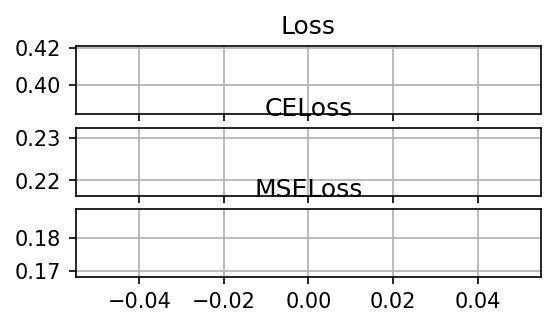

Epoch 1
-------------------------------
Epoch loss:    mean: 0.405848, ln(1+loss) mean: 0.340641
Epoch CEloss:  mean: 0.225511, ln(1+loss) mean: 0.203358
Epoch MSEloss: mean: 0.180338, ln(1+loss) mean: 0.165801
Epoch loss:    mean: 0.396751, ln(1+loss) mean: 0.334149
Epoch CEloss:  mean: 0.212730, ln(1+loss) mean: 0.192874
Epoch MSEloss: mean: 0.184021, ln(1+loss) mean: 0.168916
scheduler.step performed after val loop


<ipython-input-31-b28cca4bf2bd>:68: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  loss_hist = loss_hist.append(epochloss)


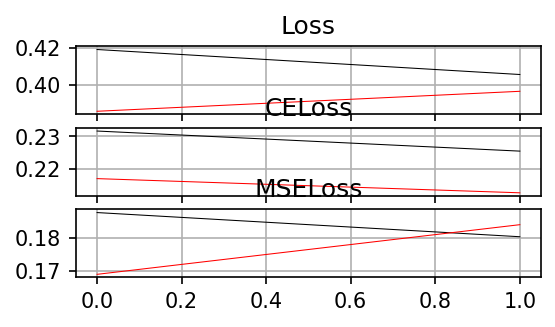

Epoch 2
-------------------------------
Epoch loss:    mean: 0.404005, ln(1+loss) mean: 0.339329
Epoch CEloss:  mean: 0.223421, ln(1+loss) mean: 0.201651
Epoch MSEloss: mean: 0.180584, ln(1+loss) mean: 0.166009
Epoch loss:    mean: 0.396376, ln(1+loss) mean: 0.333880
Epoch CEloss:  mean: 0.215716, ln(1+loss) mean: 0.195333
Epoch MSEloss: mean: 0.180660, ln(1+loss) mean: 0.166073
scheduler.step performed after val loop


<ipython-input-31-b28cca4bf2bd>:68: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  loss_hist = loss_hist.append(epochloss)


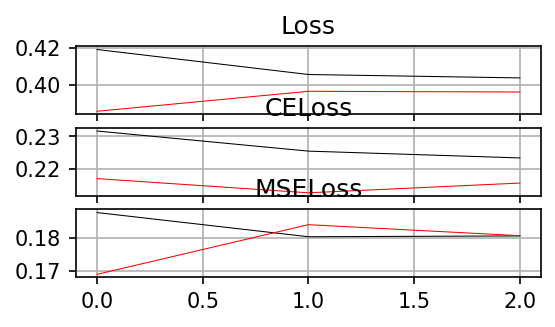

Epoch 3
-------------------------------
Epoch loss:    mean: 0.402037, ln(1+loss) mean: 0.337926
Epoch CEloss:  mean: 0.222258, ln(1+loss) mean: 0.200700
Epoch MSEloss: mean: 0.179780, ln(1+loss) mean: 0.165328
Epoch loss:    mean: 0.376255, ln(1+loss) mean: 0.319366
Epoch CEloss:  mean: 0.206195, ln(1+loss) mean: 0.187470
Epoch MSEloss: mean: 0.170060, ln(1+loss) mean: 0.157055
scheduler.step performed after val loop


<ipython-input-31-b28cca4bf2bd>:68: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  loss_hist = loss_hist.append(epochloss)


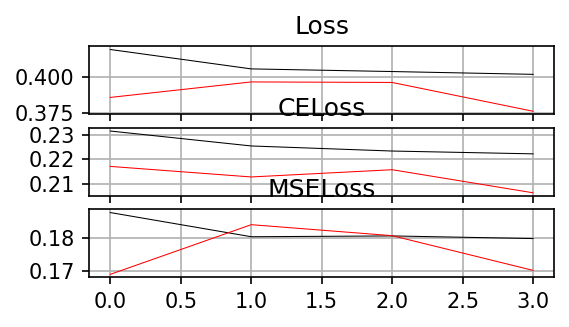

Epoch 4
-------------------------------
Epoch loss:    mean: 0.402612, ln(1+loss) mean: 0.338336
Epoch CEloss:  mean: 0.222657, ln(1+loss) mean: 0.201026
Epoch MSEloss: mean: 0.179955, ln(1+loss) mean: 0.165477
Epoch loss:    mean: 0.393123, ln(1+loss) mean: 0.331548
Epoch CEloss:  mean: 0.214450, ln(1+loss) mean: 0.194291
Epoch MSEloss: mean: 0.178674, ln(1+loss) mean: 0.164390
scheduler.step performed after val loop


<ipython-input-31-b28cca4bf2bd>:68: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  loss_hist = loss_hist.append(epochloss)


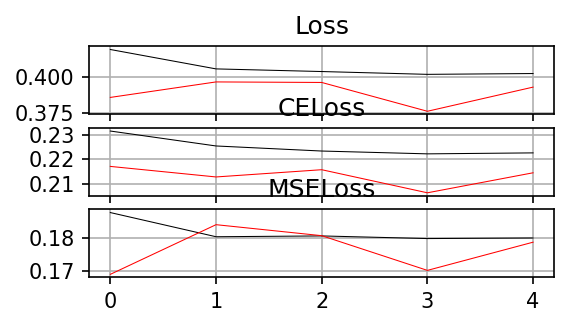

Epoch 5
-------------------------------
Epoch loss:    mean: 0.403685, ln(1+loss) mean: 0.339101
Epoch CEloss:  mean: 0.223489, ln(1+loss) mean: 0.201706
Epoch MSEloss: mean: 0.180196, ln(1+loss) mean: 0.165681
Epoch loss:    mean: 0.384659, ln(1+loss) mean: 0.325454
Epoch CEloss:  mean: 0.216725, ln(1+loss) mean: 0.196163
Epoch MSEloss: mean: 0.167934, ln(1+loss) mean: 0.155236
scheduler.step performed after val loop


<ipython-input-31-b28cca4bf2bd>:68: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  loss_hist = loss_hist.append(epochloss)


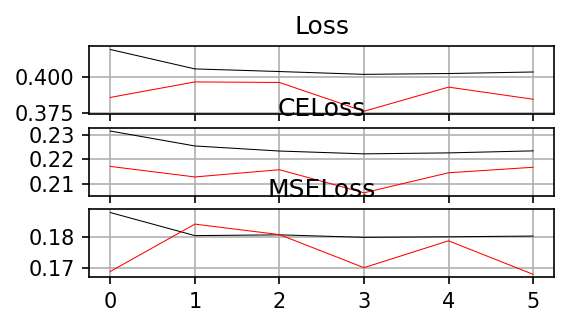

Epoch 6
-------------------------------
Epoch loss:    mean: 0.401076, ln(1+loss) mean: 0.337240
Epoch CEloss:  mean: 0.222322, ln(1+loss) mean: 0.200753
Epoch MSEloss: mean: 0.178753, ln(1+loss) mean: 0.164457
Epoch loss:    mean: 0.395768, ln(1+loss) mean: 0.333445
Epoch CEloss:  mean: 0.215393, ln(1+loss) mean: 0.195067
Epoch MSEloss: mean: 0.180375, ln(1+loss) mean: 0.165832
scheduler.step performed after val loop


<ipython-input-31-b28cca4bf2bd>:68: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  loss_hist = loss_hist.append(epochloss)


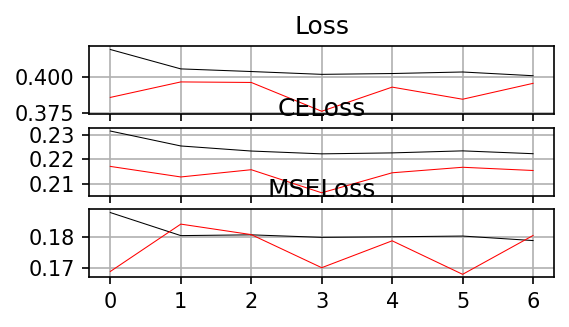

Epoch 7
-------------------------------
Epoch loss:    mean: 0.402863, ln(1+loss) mean: 0.338515
Epoch CEloss:  mean: 0.222882, ln(1+loss) mean: 0.201210
Epoch MSEloss: mean: 0.179980, ln(1+loss) mean: 0.165497
Epoch loss:    mean: 0.378336, ln(1+loss) mean: 0.320877
Epoch CEloss:  mean: 0.211233, ln(1+loss) mean: 0.191639
Epoch MSEloss: mean: 0.167104, ln(1+loss) mean: 0.154525
Epoch 00008: reducing learning rate of group 0 to 1.0000e-03.
scheduler.step performed after val loop


<ipython-input-31-b28cca4bf2bd>:68: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  loss_hist = loss_hist.append(epochloss)


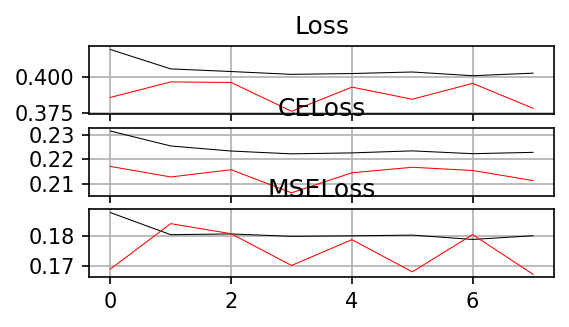

Epoch 8
-------------------------------
Epoch loss:    mean: 0.385803, ln(1+loss) mean: 0.326280
Epoch CEloss:  mean: 0.215733, ln(1+loss) mean: 0.195347
Epoch MSEloss: mean: 0.170070, ln(1+loss) mean: 0.157064
Epoch loss:    mean: 0.370578, ln(1+loss) mean: 0.315233
Epoch CEloss:  mean: 0.204393, ln(1+loss) mean: 0.185976
Epoch MSEloss: mean: 0.166185, ln(1+loss) mean: 0.153738
scheduler.step performed after val loop


<ipython-input-31-b28cca4bf2bd>:68: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  loss_hist = loss_hist.append(epochloss)


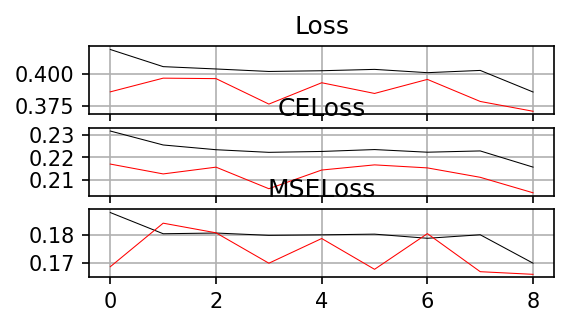

Epoch 9
-------------------------------
Epoch loss:    mean: 0.383379, ln(1+loss) mean: 0.324529
Epoch CEloss:  mean: 0.213692, ln(1+loss) mean: 0.193667
Epoch MSEloss: mean: 0.169687, ln(1+loss) mean: 0.156736
Epoch loss:    mean: 0.369594, ln(1+loss) mean: 0.314514
Epoch CEloss:  mean: 0.202245, ln(1+loss) mean: 0.184191
Epoch MSEloss: mean: 0.167349, ln(1+loss) mean: 0.154735
scheduler.step performed after val loop


<ipython-input-31-b28cca4bf2bd>:68: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  loss_hist = loss_hist.append(epochloss)


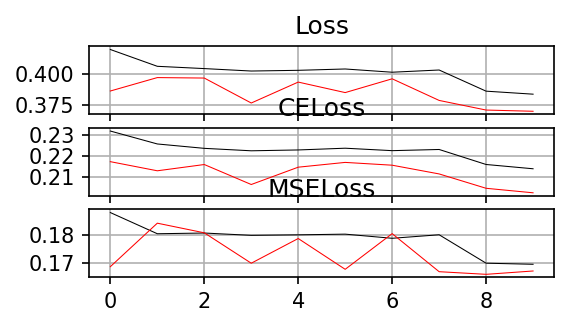

Epoch 10
-------------------------------
Epoch loss:    mean: 0.382010, ln(1+loss) mean: 0.323539
Epoch CEloss:  mean: 0.212875, ln(1+loss) mean: 0.192994
Epoch MSEloss: mean: 0.169134, ln(1+loss) mean: 0.156264
Epoch loss:    mean: 0.367950, ln(1+loss) mean: 0.313313
Epoch CEloss:  mean: 0.202262, ln(1+loss) mean: 0.184205
Epoch MSEloss: mean: 0.165688, ln(1+loss) mean: 0.153311
scheduler.step performed after val loop


<ipython-input-31-b28cca4bf2bd>:68: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  loss_hist = loss_hist.append(epochloss)


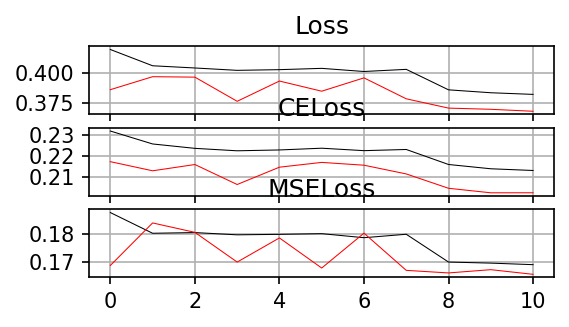

Epoch 11
-------------------------------
Epoch loss:    mean: 0.382381, ln(1+loss) mean: 0.323808
Epoch CEloss:  mean: 0.212842, ln(1+loss) mean: 0.192967
Epoch MSEloss: mean: 0.169538, ln(1+loss) mean: 0.156609
Epoch loss:    mean: 0.368777, ln(1+loss) mean: 0.313917
Epoch CEloss:  mean: 0.202557, ln(1+loss) mean: 0.184450
Epoch MSEloss: mean: 0.166220, ln(1+loss) mean: 0.153767
scheduler.step performed after val loop


<ipython-input-31-b28cca4bf2bd>:68: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  loss_hist = loss_hist.append(epochloss)


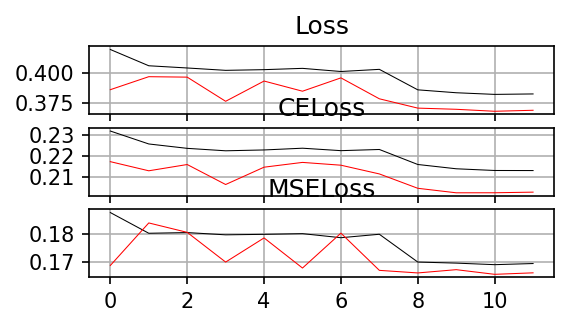

Epoch 12
-------------------------------
Epoch loss:    mean: 0.381718, ln(1+loss) mean: 0.323327
Epoch CEloss:  mean: 0.212486, ln(1+loss) mean: 0.192673
Epoch MSEloss: mean: 0.169232, ln(1+loss) mean: 0.156347
Epoch loss:    mean: 0.368371, ln(1+loss) mean: 0.313621
Epoch CEloss:  mean: 0.202407, ln(1+loss) mean: 0.184326
Epoch MSEloss: mean: 0.165964, ln(1+loss) mean: 0.153548
scheduler.step performed after val loop


<ipython-input-31-b28cca4bf2bd>:68: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  loss_hist = loss_hist.append(epochloss)


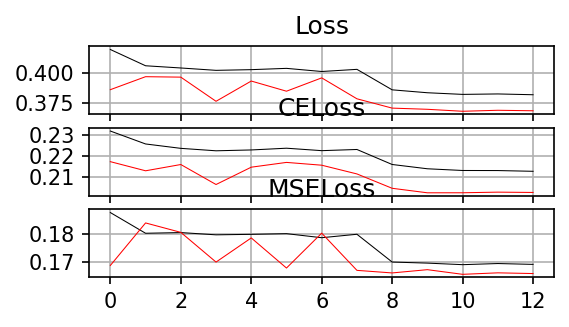

Epoch 13
-------------------------------
Epoch loss:    mean: 0.381531, ln(1+loss) mean: 0.323192
Epoch CEloss:  mean: 0.211996, ln(1+loss) mean: 0.192269
Epoch MSEloss: mean: 0.169535, ln(1+loss) mean: 0.156606
Epoch loss:    mean: 0.368098, ln(1+loss) mean: 0.313422
Epoch CEloss:  mean: 0.202324, ln(1+loss) mean: 0.184256
Epoch MSEloss: mean: 0.165774, ln(1+loss) mean: 0.153385
scheduler.step performed after val loop


<ipython-input-31-b28cca4bf2bd>:68: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  loss_hist = loss_hist.append(epochloss)


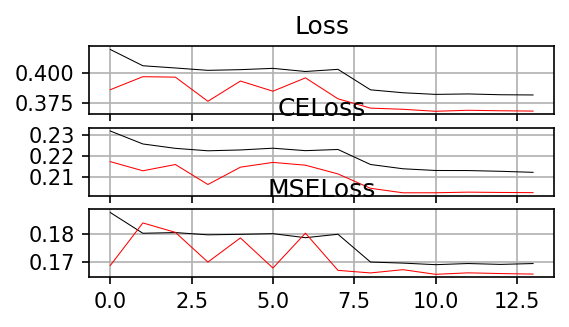

Epoch 14
-------------------------------
Epoch loss:    mean: 0.380802, ln(1+loss) mean: 0.322665
Epoch CEloss:  mean: 0.211872, ln(1+loss) mean: 0.192166
Epoch MSEloss: mean: 0.168930, ln(1+loss) mean: 0.156089
Epoch loss:    mean: 0.369973, ln(1+loss) mean: 0.314791
Epoch CEloss:  mean: 0.203613, ln(1+loss) mean: 0.185328
Epoch MSEloss: mean: 0.166360, ln(1+loss) mean: 0.153887
Epoch 00015: reducing learning rate of group 0 to 1.0000e-04.
scheduler.step performed after val loop


<ipython-input-31-b28cca4bf2bd>:68: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  loss_hist = loss_hist.append(epochloss)


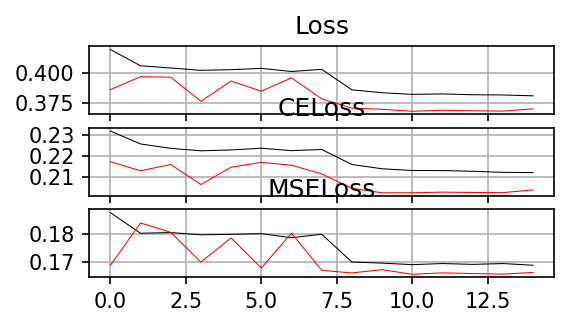

Epoch 15
-------------------------------
Epoch loss:    mean: 0.379294, ln(1+loss) mean: 0.321572
Epoch CEloss:  mean: 0.210982, ln(1+loss) mean: 0.191432
Epoch MSEloss: mean: 0.168313, ln(1+loss) mean: 0.155561
Epoch loss:    mean: 0.367759, ln(1+loss) mean: 0.313173
Epoch CEloss:  mean: 0.202385, ln(1+loss) mean: 0.184307
Epoch MSEloss: mean: 0.165374, ln(1+loss) mean: 0.153042
scheduler.step performed after val loop


<ipython-input-31-b28cca4bf2bd>:68: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  loss_hist = loss_hist.append(epochloss)


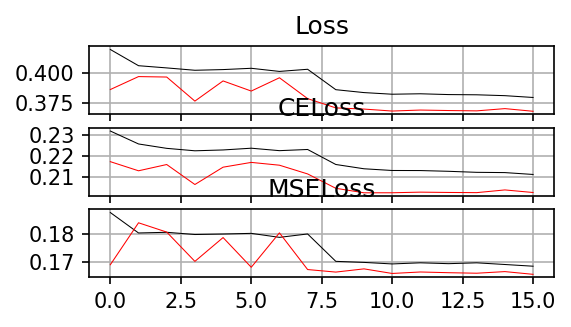

Epoch 16
-------------------------------
Epoch loss:    mean: 0.378648, ln(1+loss) mean: 0.321103
Epoch CEloss:  mean: 0.210625, ln(1+loss) mean: 0.191137
Epoch MSEloss: mean: 0.168023, ln(1+loss) mean: 0.155312
Epoch loss:    mean: 0.367524, ln(1+loss) mean: 0.313002
Epoch CEloss:  mean: 0.202156, ln(1+loss) mean: 0.184117
Epoch MSEloss: mean: 0.165367, ln(1+loss) mean: 0.153036
scheduler.step performed after val loop


<ipython-input-31-b28cca4bf2bd>:68: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  loss_hist = loss_hist.append(epochloss)


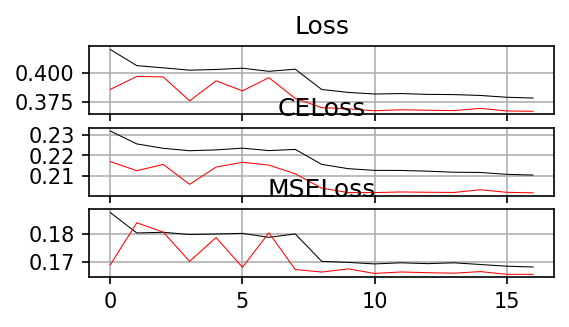

Epoch 17
-------------------------------
Epoch loss:    mean: 0.378725, ln(1+loss) mean: 0.321159
Epoch CEloss:  mean: 0.210397, ln(1+loss) mean: 0.190949
Epoch MSEloss: mean: 0.168328, ln(1+loss) mean: 0.155573
Epoch loss:    mean: 0.367704, ln(1+loss) mean: 0.313133
Epoch CEloss:  mean: 0.202335, ln(1+loss) mean: 0.184265
Epoch MSEloss: mean: 0.165369, ln(1+loss) mean: 0.153038
scheduler.step performed after val loop


<ipython-input-31-b28cca4bf2bd>:68: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  loss_hist = loss_hist.append(epochloss)


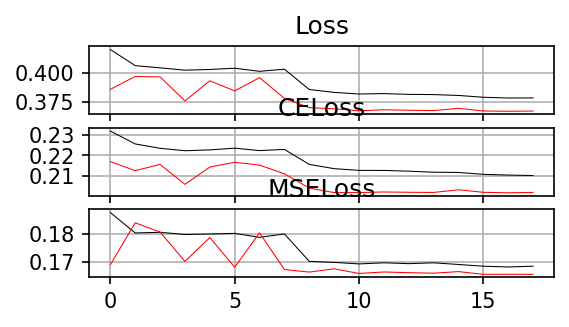

Epoch 18
-------------------------------
Epoch loss:    mean: 0.378649, ln(1+loss) mean: 0.321104
Epoch CEloss:  mean: 0.210200, ln(1+loss) mean: 0.190786
Epoch MSEloss: mean: 0.168448, ln(1+loss) mean: 0.155677
Epoch loss:    mean: 0.367506, ln(1+loss) mean: 0.312989
Epoch CEloss:  mean: 0.202035, ln(1+loss) mean: 0.184016
Epoch MSEloss: mean: 0.165471, ln(1+loss) mean: 0.153125
scheduler.step performed after val loop


<ipython-input-31-b28cca4bf2bd>:68: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  loss_hist = loss_hist.append(epochloss)


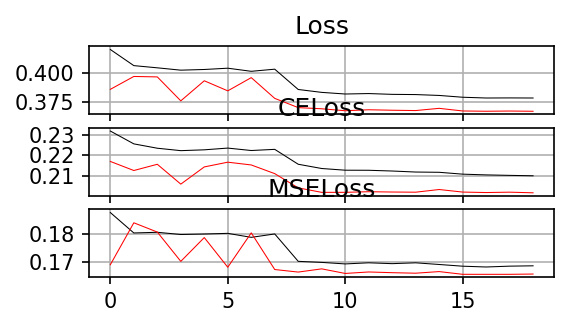

Epoch 19
-------------------------------
Epoch loss:    mean: 0.378788, ln(1+loss) mean: 0.321205
Epoch CEloss:  mean: 0.210293, ln(1+loss) mean: 0.190862
Epoch MSEloss: mean: 0.168495, ln(1+loss) mean: 0.155717
Epoch loss:    mean: 0.367598, ln(1+loss) mean: 0.313056
Epoch CEloss:  mean: 0.202080, ln(1+loss) mean: 0.184053
Epoch MSEloss: mean: 0.165518, ln(1+loss) mean: 0.153165
scheduler.step performed after val loop


<ipython-input-31-b28cca4bf2bd>:68: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  loss_hist = loss_hist.append(epochloss)


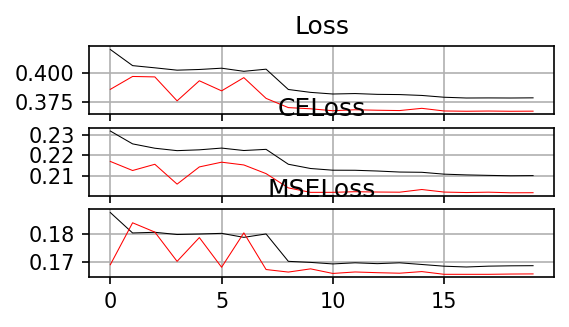

Epoch 20
-------------------------------
Epoch loss:    mean: 0.378414, ln(1+loss) mean: 0.320933
Epoch CEloss:  mean: 0.210170, ln(1+loss) mean: 0.190761
Epoch MSEloss: mean: 0.168244, ln(1+loss) mean: 0.155502
Epoch loss:    mean: 0.367766, ln(1+loss) mean: 0.313179
Epoch CEloss:  mean: 0.201978, ln(1+loss) mean: 0.183968
Epoch MSEloss: mean: 0.165788, ln(1+loss) mean: 0.153397
Epoch 00021: reducing learning rate of group 0 to 1.0000e-05.
scheduler.step performed after val loop


<ipython-input-31-b28cca4bf2bd>:68: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  loss_hist = loss_hist.append(epochloss)


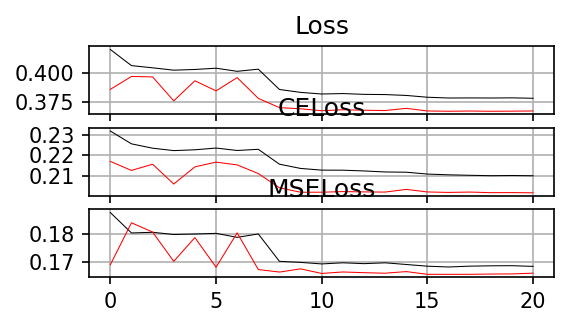

Epoch 21
-------------------------------
Epoch loss:    mean: 0.378393, ln(1+loss) mean: 0.320919
Epoch CEloss:  mean: 0.210048, ln(1+loss) mean: 0.190660
Epoch MSEloss: mean: 0.168345, ln(1+loss) mean: 0.155588
Epoch loss:    mean: 0.367470, ln(1+loss) mean: 0.312962
Epoch CEloss:  mean: 0.201935, ln(1+loss) mean: 0.183933
Epoch MSEloss: mean: 0.165535, ln(1+loss) mean: 0.153180
scheduler.step performed after val loop


<ipython-input-31-b28cca4bf2bd>:68: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  loss_hist = loss_hist.append(epochloss)


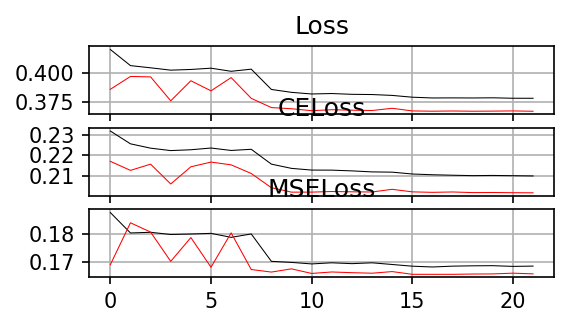

Epoch 22
-------------------------------
Epoch loss:    mean: 0.378244, ln(1+loss) mean: 0.320810
Epoch CEloss:  mean: 0.210114, ln(1+loss) mean: 0.190715
Epoch MSEloss: mean: 0.168130, ln(1+loss) mean: 0.155404
Epoch loss:    mean: 0.367397, ln(1+loss) mean: 0.312909
Epoch CEloss:  mean: 0.201952, ln(1+loss) mean: 0.183947
Epoch MSEloss: mean: 0.165445, ln(1+loss) mean: 0.153103
scheduler.step performed after val loop


<ipython-input-31-b28cca4bf2bd>:68: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  loss_hist = loss_hist.append(epochloss)


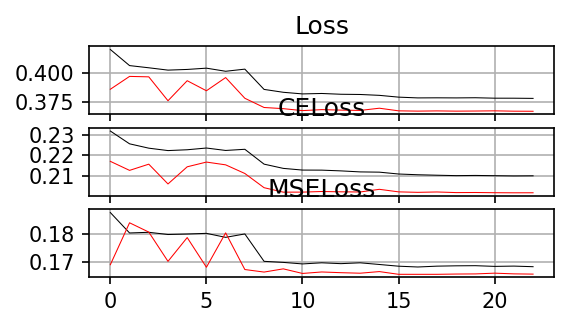

Epoch 23
-------------------------------
Epoch loss:    mean: 0.378424, ln(1+loss) mean: 0.320941
Epoch CEloss:  mean: 0.210088, ln(1+loss) mean: 0.190693
Epoch MSEloss: mean: 0.168337, ln(1+loss) mean: 0.155581
Epoch loss:    mean: 0.367431, ln(1+loss) mean: 0.312933
Epoch CEloss:  mean: 0.201961, ln(1+loss) mean: 0.183955
Epoch MSEloss: mean: 0.165469, ln(1+loss) mean: 0.153124
scheduler.step performed after val loop


<ipython-input-31-b28cca4bf2bd>:68: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  loss_hist = loss_hist.append(epochloss)


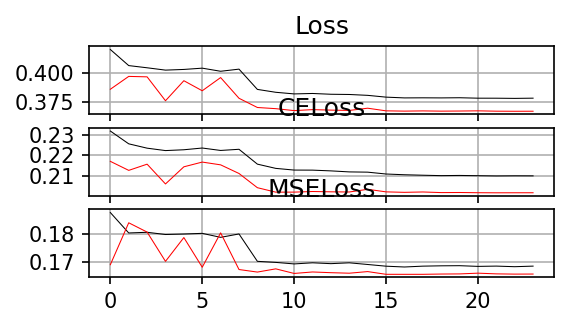

Epoch 24
-------------------------------
Epoch loss:    mean: 0.378271, ln(1+loss) mean: 0.320830
Epoch CEloss:  mean: 0.209948, ln(1+loss) mean: 0.190577
Epoch MSEloss: mean: 0.168324, ln(1+loss) mean: 0.155570
Epoch loss:    mean: 0.367423, ln(1+loss) mean: 0.312928
Epoch CEloss:  mean: 0.201960, ln(1+loss) mean: 0.183954
Epoch MSEloss: mean: 0.165463, ln(1+loss) mean: 0.153118
scheduler.step performed after val loop


<ipython-input-31-b28cca4bf2bd>:68: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  loss_hist = loss_hist.append(epochloss)


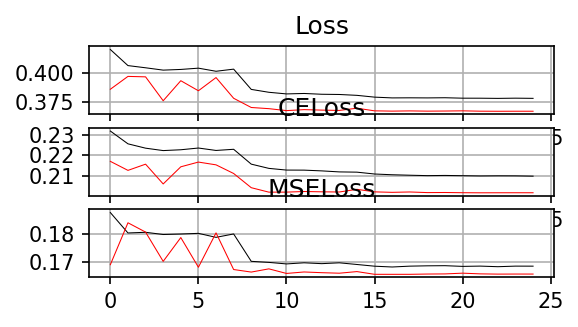

Epoch 25
-------------------------------
Epoch loss:    mean: 0.378222, ln(1+loss) mean: 0.320794
Epoch CEloss:  mean: 0.210050, ln(1+loss) mean: 0.190662
Epoch MSEloss: mean: 0.168172, ln(1+loss) mean: 0.155440
Epoch loss:    mean: 0.367439, ln(1+loss) mean: 0.312940
Epoch CEloss:  mean: 0.201968, ln(1+loss) mean: 0.183960
Epoch MSEloss: mean: 0.165470, ln(1+loss) mean: 0.153125
scheduler.step performed after val loop


<ipython-input-31-b28cca4bf2bd>:68: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  loss_hist = loss_hist.append(epochloss)


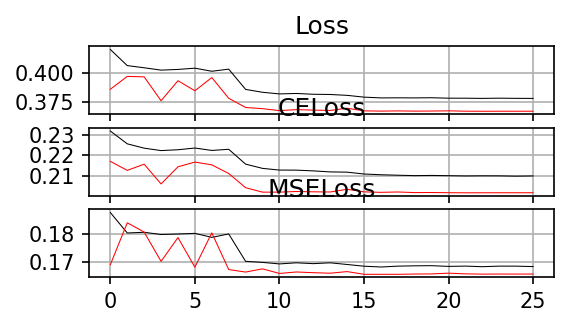

Epoch 26
-------------------------------
Epoch loss:    mean: 0.378187, ln(1+loss) mean: 0.320769
Epoch CEloss:  mean: 0.210084, ln(1+loss) mean: 0.190690
Epoch MSEloss: mean: 0.168103, ln(1+loss) mean: 0.155381
Epoch loss:    mean: 0.367410, ln(1+loss) mean: 0.312919
Epoch CEloss:  mean: 0.201957, ln(1+loss) mean: 0.183951
Epoch MSEloss: mean: 0.165453, ln(1+loss) mean: 0.153110
Epoch 00027: reducing learning rate of group 0 to 1.0000e-06.
scheduler.step performed after val loop


<ipython-input-31-b28cca4bf2bd>:68: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  loss_hist = loss_hist.append(epochloss)


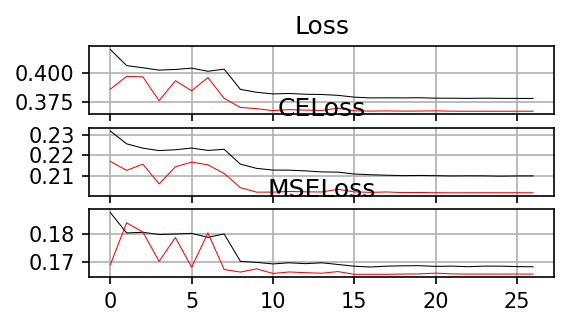

Epoch 27
-------------------------------
Epoch loss:    mean: 0.378349, ln(1+loss) mean: 0.320886
Epoch CEloss:  mean: 0.209873, ln(1+loss) mean: 0.190515
Epoch MSEloss: mean: 0.168476, ln(1+loss) mean: 0.155700
Epoch loss:    mean: 0.367413, ln(1+loss) mean: 0.312921
Epoch CEloss:  mean: 0.201957, ln(1+loss) mean: 0.183951
Epoch MSEloss: mean: 0.165456, ln(1+loss) mean: 0.153112
scheduler.step performed after val loop


<ipython-input-31-b28cca4bf2bd>:68: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  loss_hist = loss_hist.append(epochloss)


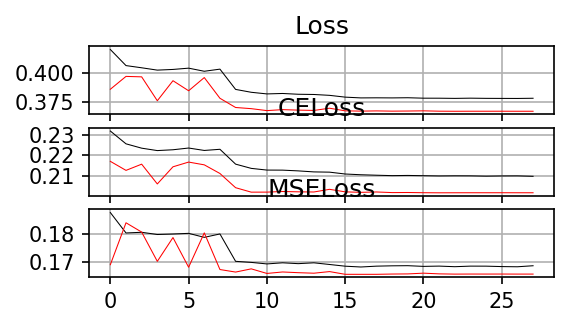

Epoch 28
-------------------------------
Epoch loss:    mean: 0.378099, ln(1+loss) mean: 0.320705
Epoch CEloss:  mean: 0.210122, ln(1+loss) mean: 0.190721
Epoch MSEloss: mean: 0.167978, ln(1+loss) mean: 0.155274
Epoch loss:    mean: 0.367412, ln(1+loss) mean: 0.312920
Epoch CEloss:  mean: 0.201958, ln(1+loss) mean: 0.183952
Epoch MSEloss: mean: 0.165454, ln(1+loss) mean: 0.153110
scheduler.step performed after val loop


<ipython-input-31-b28cca4bf2bd>:68: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  loss_hist = loss_hist.append(epochloss)


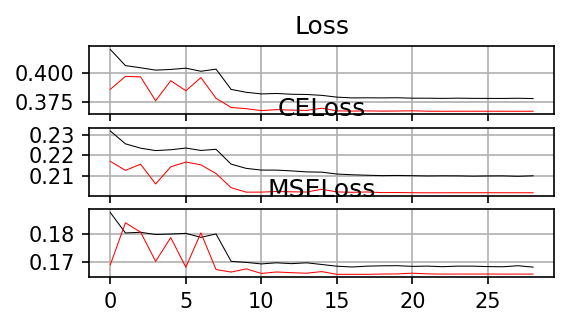

Epoch 29
-------------------------------
Epoch loss:    mean: 0.378484, ln(1+loss) mean: 0.320984
Epoch CEloss:  mean: 0.209993, ln(1+loss) mean: 0.190615
Epoch MSEloss: mean: 0.168491, ln(1+loss) mean: 0.155713
Epoch loss:    mean: 0.367413, ln(1+loss) mean: 0.312921
Epoch CEloss:  mean: 0.201958, ln(1+loss) mean: 0.183952
Epoch MSEloss: mean: 0.165455, ln(1+loss) mean: 0.153111
scheduler.step performed after val loop


<ipython-input-31-b28cca4bf2bd>:68: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  loss_hist = loss_hist.append(epochloss)


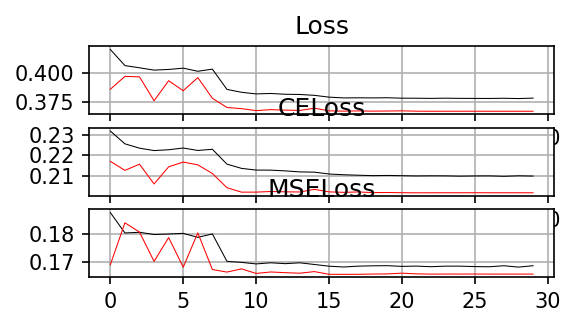

Epoch 30
-------------------------------
Epoch loss:    mean: 0.378122, ln(1+loss) mean: 0.320722
Epoch CEloss:  mean: 0.209711, ln(1+loss) mean: 0.190382
Epoch MSEloss: mean: 0.168410, ln(1+loss) mean: 0.155644
Epoch loss:    mean: 0.367416, ln(1+loss) mean: 0.312923
Epoch CEloss:  mean: 0.201958, ln(1+loss) mean: 0.183952
Epoch MSEloss: mean: 0.165458, ln(1+loss) mean: 0.153114
Epoch 00031: reducing learning rate of group 0 to 1.0000e-07.
scheduler.step performed after val loop


<ipython-input-31-b28cca4bf2bd>:68: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  loss_hist = loss_hist.append(epochloss)


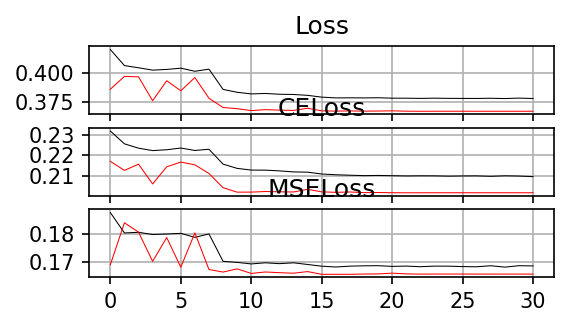

Epoch 31
-------------------------------
Epoch loss:    mean: 0.378134, ln(1+loss) mean: 0.320731
Epoch CEloss:  mean: 0.210051, ln(1+loss) mean: 0.190663
Epoch MSEloss: mean: 0.168083, ln(1+loss) mean: 0.155364
Epoch loss:    mean: 0.367417, ln(1+loss) mean: 0.312923
Epoch CEloss:  mean: 0.201958, ln(1+loss) mean: 0.183952
Epoch MSEloss: mean: 0.165458, ln(1+loss) mean: 0.153115
scheduler.step performed after val loop


<ipython-input-31-b28cca4bf2bd>:68: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  loss_hist = loss_hist.append(epochloss)


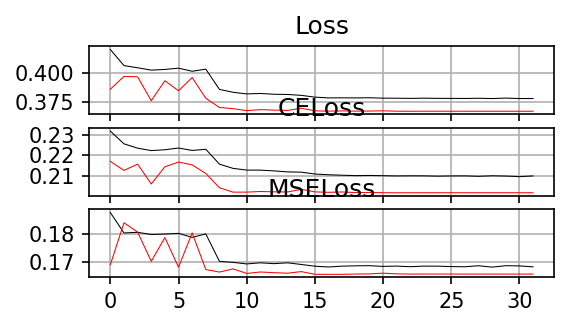

Epoch 32
-------------------------------
Epoch loss:    mean: 0.378517, ln(1+loss) mean: 0.321008
Epoch CEloss:  mean: 0.209839, ln(1+loss) mean: 0.190487
Epoch MSEloss: mean: 0.168679, ln(1+loss) mean: 0.155874
Epoch loss:    mean: 0.367417, ln(1+loss) mean: 0.312923
Epoch CEloss:  mean: 0.201959, ln(1+loss) mean: 0.183952
Epoch MSEloss: mean: 0.165458, ln(1+loss) mean: 0.153114
scheduler.step performed after val loop


<ipython-input-31-b28cca4bf2bd>:68: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  loss_hist = loss_hist.append(epochloss)


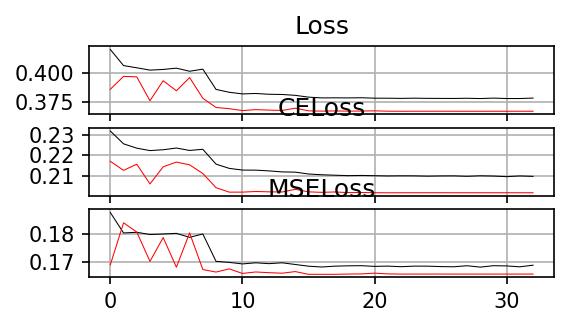

Epoch 33
-------------------------------
Epoch loss:    mean: 0.378224, ln(1+loss) mean: 0.320795
Epoch CEloss:  mean: 0.209847, ln(1+loss) mean: 0.190494
Epoch MSEloss: mean: 0.168377, ln(1+loss) mean: 0.155616
Epoch loss:    mean: 0.367417, ln(1+loss) mean: 0.312923
Epoch CEloss:  mean: 0.201959, ln(1+loss) mean: 0.183953
Epoch MSEloss: mean: 0.165458, ln(1+loss) mean: 0.153114
scheduler.step performed after val loop


<ipython-input-31-b28cca4bf2bd>:68: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  loss_hist = loss_hist.append(epochloss)


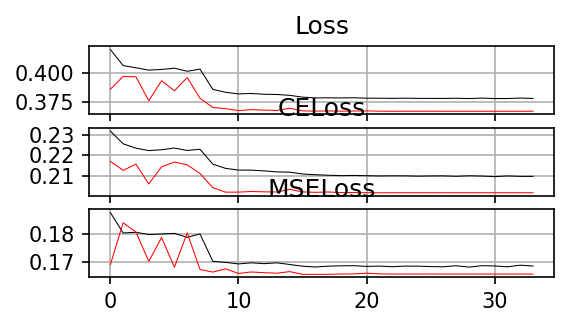

Epoch 34
-------------------------------
Epoch loss:    mean: 0.377969, ln(1+loss) mean: 0.320611
Epoch CEloss:  mean: 0.210039, ln(1+loss) mean: 0.190653
Epoch MSEloss: mean: 0.167931, ln(1+loss) mean: 0.155234
Epoch loss:    mean: 0.367417, ln(1+loss) mean: 0.312923
Epoch CEloss:  mean: 0.201959, ln(1+loss) mean: 0.183953
Epoch MSEloss: mean: 0.165457, ln(1+loss) mean: 0.153114
Epoch 00035: reducing learning rate of group 0 to 1.0000e-08.
scheduler.step performed after val loop


<ipython-input-31-b28cca4bf2bd>:68: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  loss_hist = loss_hist.append(epochloss)


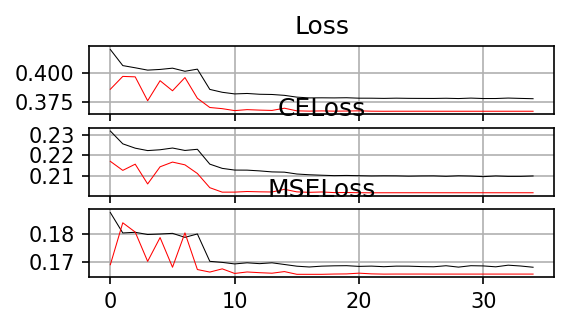

Calculating test loss
Epoch loss:    mean: 0.378438, ln(1+loss) mean: 0.320951
Epoch CEloss:  mean: 0.209769, ln(1+loss) mean: 0.190429
Epoch MSEloss: mean: 0.168669, ln(1+loss) mean: 0.155866


<ipython-input-31-b28cca4bf2bd>:93: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  loss_hist = loss_hist.append(epochloss)


In [ ]:
num_action_cats = num_chars
act_padding_idx = 1
scale_grad_by_freq = True
num_contvars_in  = len(input_vars) - 1
num_contvars_out = len(target_vars) - 1
transformer_finaldenselayer_dim = 64

cat_embedding_dim = 7
cont_embedding_dim = 10
num_layers = 1
dim_feedforward = 8
model_type = "Transformer"
transformer_nhead = 1

from datetime import datetime
all_loss = np.empty((0,14))


d_model = cat_embedding_dim + cont_embedding_dim
final_loss = go()
config = np.array([cat_embedding_dim,cont_embedding_dim,num_layers,dim_feedforward,model_type])
all_loss = np.vstack((all_loss,np.hstack((config,final_loss))))
date = datetime.now().strftime("%Y_%m_%d-%H%M%S")
np.savetxt(f"/content/drive/Shared drives/Soccer Event Prediction/model_res_{date}.csv",all_loss,delimiter=",",fmt='%s')